In [92]:
import matplotlib.pylab as plt
import platform
import os
import glob
import pandas
import numpy
from matplotlib_scalebar.scalebar import ScaleBar

In [121]:
# Turn off warning in the notebook
import warnings
warnings.filterwarnings("ignore")

In [122]:
# Setup display
plt.rc('image', cmap='viridis', interpolation='nearest')
plt.rcParams['figure.figsize'] = (16, 9)

In [123]:
# Setup scale bar
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [124]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [125]:
def get_git_hash():
    """
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    """
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git',
                        '--git-dir',
                        os.path.join(os.getcwd(), '.git'),
                        'rev-parse',
                        '--short',
                        '--verify',
                        'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [126]:
# Work on the fast SSD from here on!
FastSSD = True
if 'debian' in platform.dist():
    if FastSSD:
        StartDir = '/media/habi/Fast_SSD/'
    else:
        StartDir = '/media/habi/Blue Seagate/'
else:
    if FastSSD:
        StartDir = 'F:/'
    else:
        StartDir = 'G:/'
RootFolder = os.path.join(StartDir, 'Zebra-Fish_Matthias')

In [127]:
print('We are loading all the data from %s' % RootFolder)

We are loading all the data from /media/habi/Fast_SSD/Zebra-Fish_Matthias


In [128]:
# Make directory for output
OutPutDir = os.path.join(os.getcwd(), 'Output', get_git_hash())
print('We are saving all the output to %s' % OutPutDir)
os.makedirs(OutPutDir, exist_ok=True)

We are saving all the output to /home/habi/P/Documents/Zebrafish-Gills/Output/8fa5bfc


In [129]:
# Get all the 'Control' and 'Swimmer' folders in the root folder
# https://stackoverflow.com/a/34507323/323100
SampleNames = glob.glob(os.path.join(RootFolder, 'Control*')) + glob.glob(os.path.join(RootFolder, 'Swimmer*'))

In [130]:
# Generate and start dataframe
Data = pandas.DataFrame()
Data['Sample'] = [os.path.basename(sn) for sn in SampleNames]

In [131]:
# Get the needed details
Data['LogFile'] = [sorted(glob.glob(os.path.join(RootFolder, f, 'proj', '*.log')))[0] for f in Data.Sample]
Data['PixelSize'] = [get_pixelsize(logfile) for logfile in Data.LogFile]

In [132]:
# Construct filenames of gills and organ hulls
# Only find the files with an average threshold (...thresholded_with-??.??...)
Data['Filename_Gills'] = [glob.glob(os.path.join(RootFolder,
                                                 fish,
                                                 fish + '*with-*.??.npy'))[0] for fish in Data.Sample]
Data['Filename_Organ'] = [glob.glob(os.path.join(RootFolder,
                                                 fish,
                                                 fish + '*with-*.??_organ*.npy'))[0] for fish in Data.Sample]

In [133]:
def display_difference(item):
    """
    Load the gills and hull image into memory.
    Calculate the difference and display the middle slices in each cardinal directions
    """
    hull = numpy.load(Data.Filename_Organ[item], mmap_mode='r').astype('uint8')
    gills = numpy.load(Data.Filename_Gills[item], mmap_mode='r').astype('uint8')
    # Calculate a difference image
    # We multiply the gills by two, otherwise we won't see a difference :)
    difference = numpy.add(hull, gills * 2)
    plt.subplot(1,3,1)
    plt.imshow(difference[numpy.shape(difference)[0]//2,:,:])
    plt.gca().add_artist(ScaleBar(Data.PixelSize[item], 'um'))
    plt.axis('off')
    plt.title('%s, z-slice %s' % (Data.Sample[item], numpy.shape(difference)[0]//2))
    plt.subplot(1,3,2)
    plt.imshow(difference[:,numpy.shape(difference)[1]//2,:])
    plt.gca().add_artist(ScaleBar(Data.PixelSize[item], 'um'))
    plt.axis('off')
    plt.title('%s, x-slice %s' % (Data.Sample[item], numpy.shape(difference)[1]//2))
    plt.subplot(1,3,3)
    plt.imshow(difference[:,:,numpy.shape(difference)[2]//2])
    plt.title('%s, y-slice %s' % (Data.Sample[item], numpy.shape(difference)[2]//2))
    plt.gca().add_artist(ScaleBar(Data.PixelSize[item], 'um'))
    plt.axis('off')
    plt.savefig(os.path.join(OutPutDir,
                             'Hull-Gill-Difference_' + Data.Sample[item] + '.png'),
                bbox_inches='tight')
    plt.show()    

 1/20: Saving difference images for sample Control09


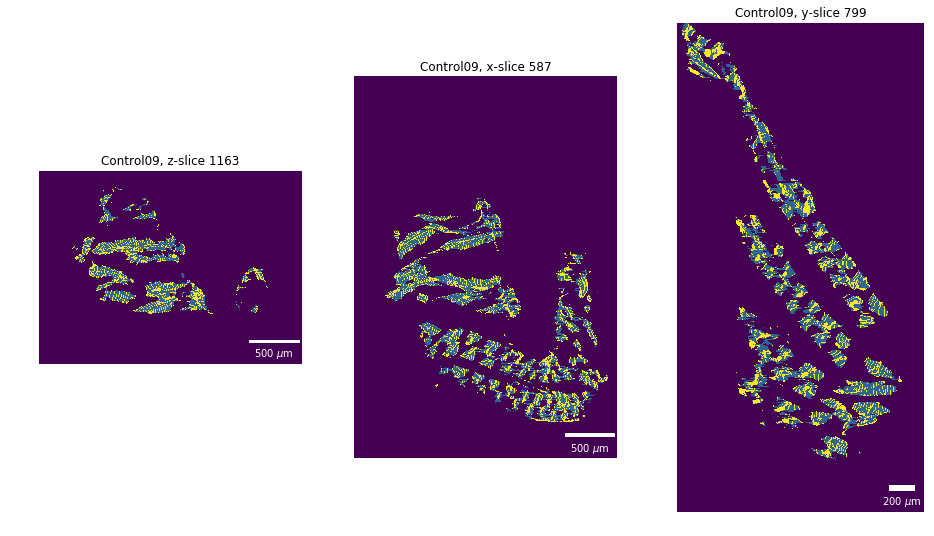

 2/20: Saving difference images for sample Control01


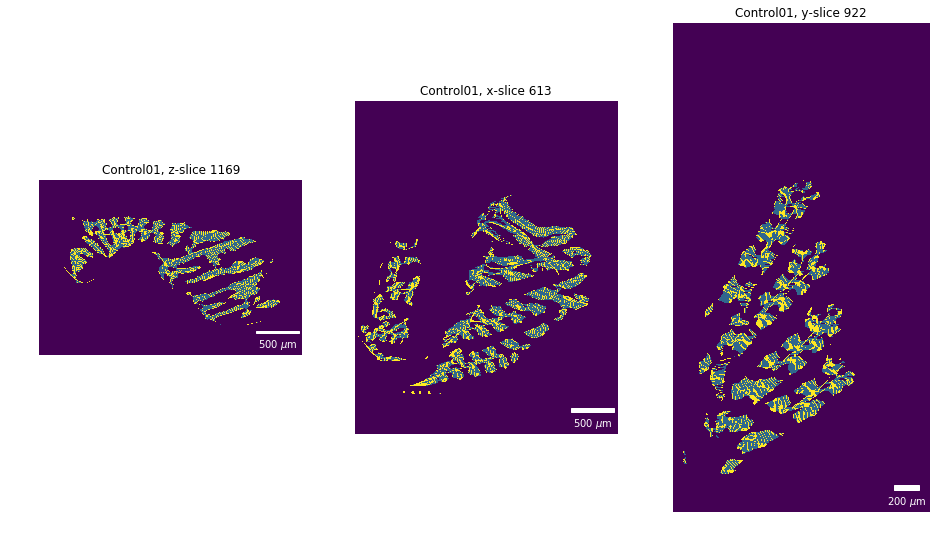

 3/20: Saving difference images for sample Control02


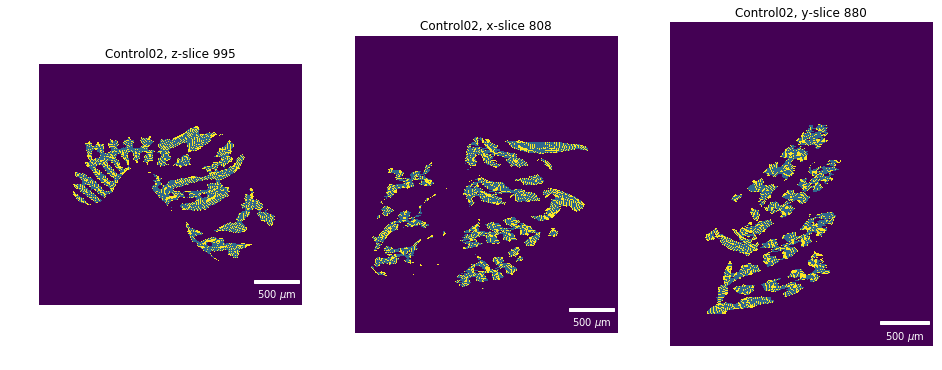

 4/20: Saving difference images for sample Control03


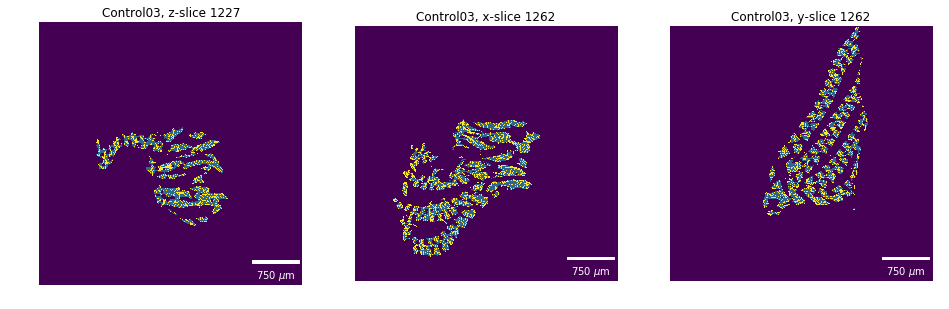

 5/20: Saving difference images for sample Control04


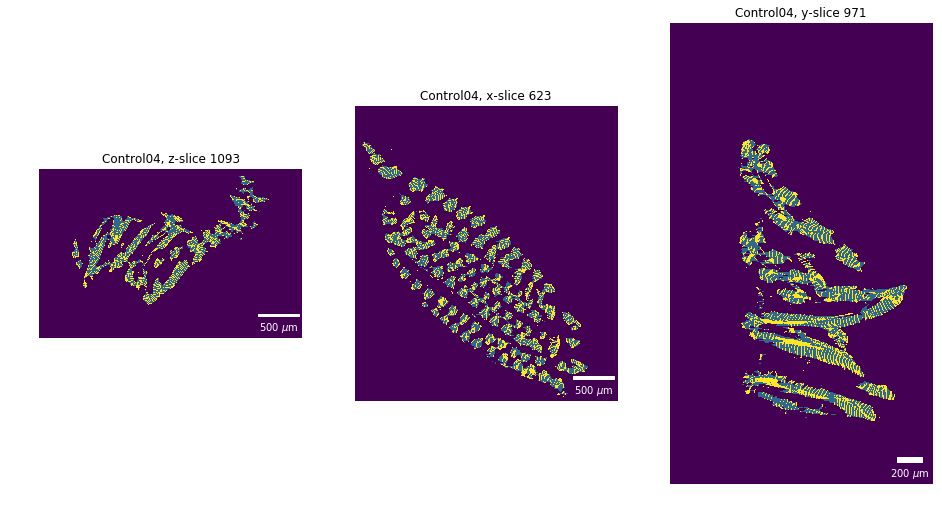

 6/20: Saving difference images for sample Control05


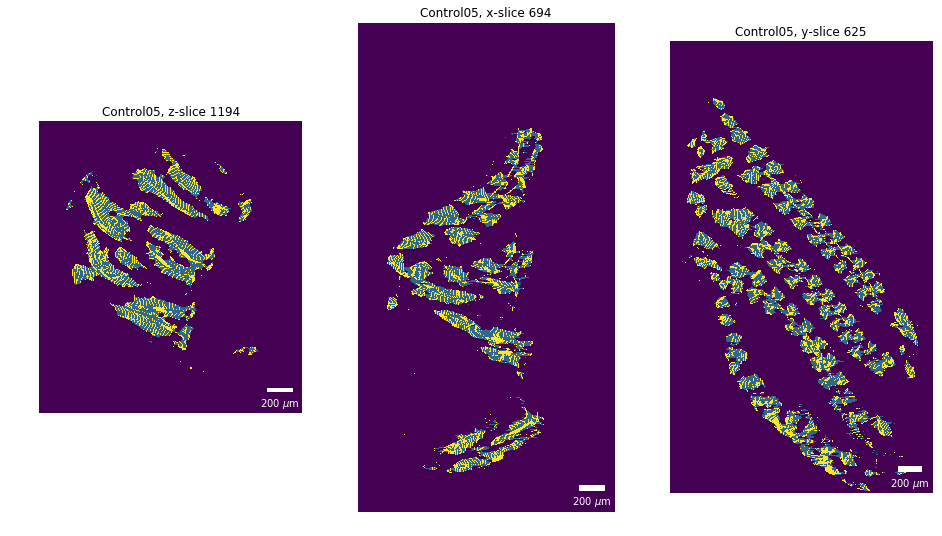

 7/20: Saving difference images for sample Control06


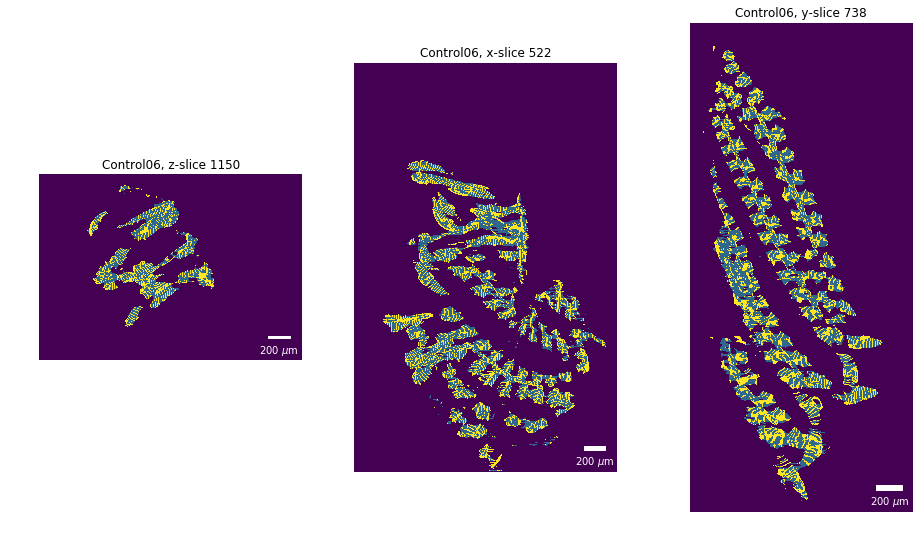

 8/20: Saving difference images for sample Control07


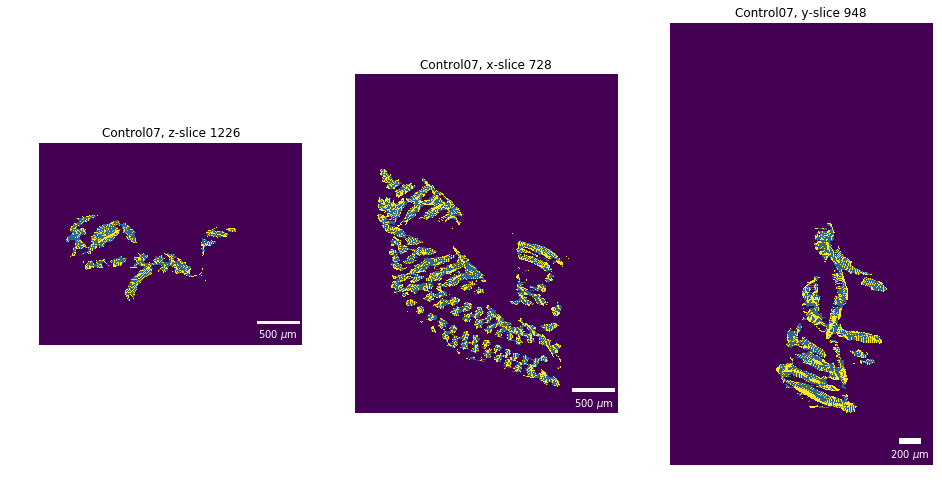

 9/20: Saving difference images for sample Control08


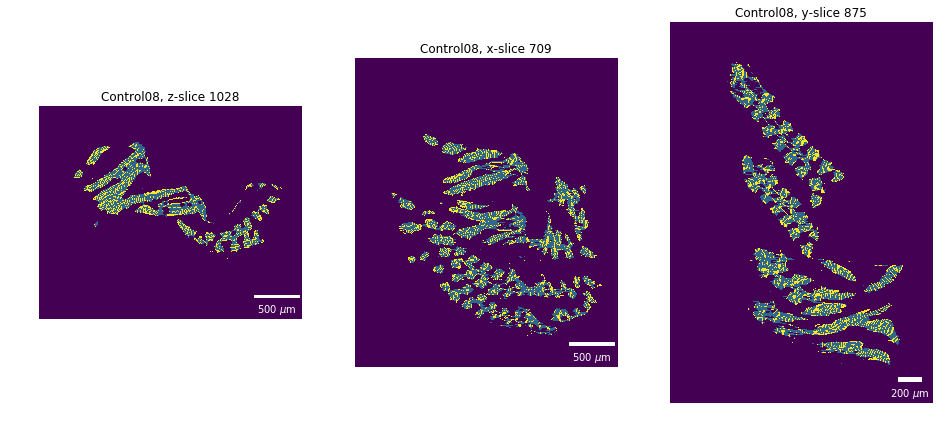

10/20: Saving difference images for sample Control10


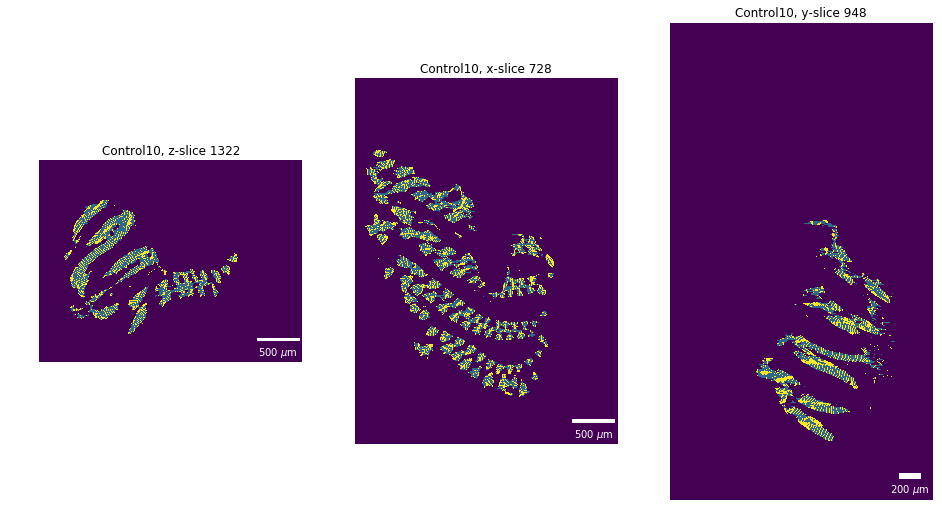

11/20: Saving difference images for sample Swimmer01


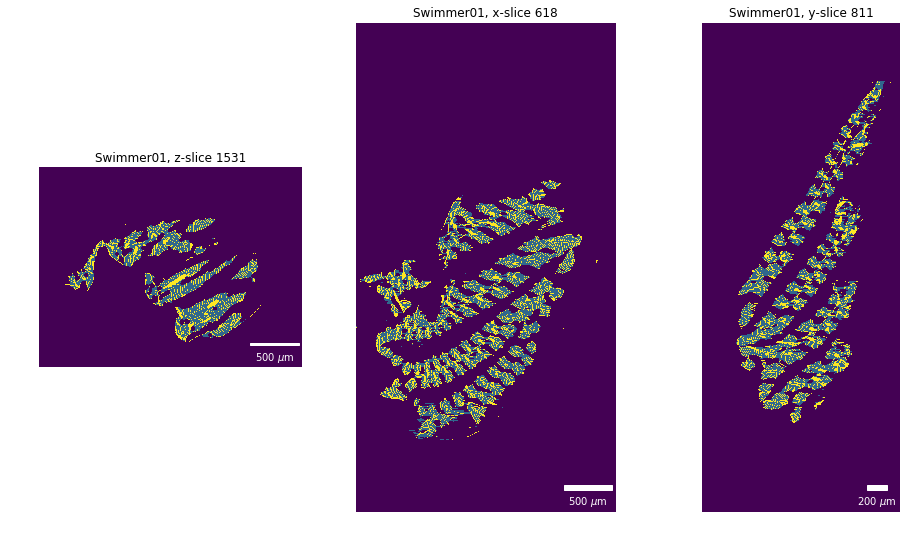

12/20: Saving difference images for sample Swimmer02


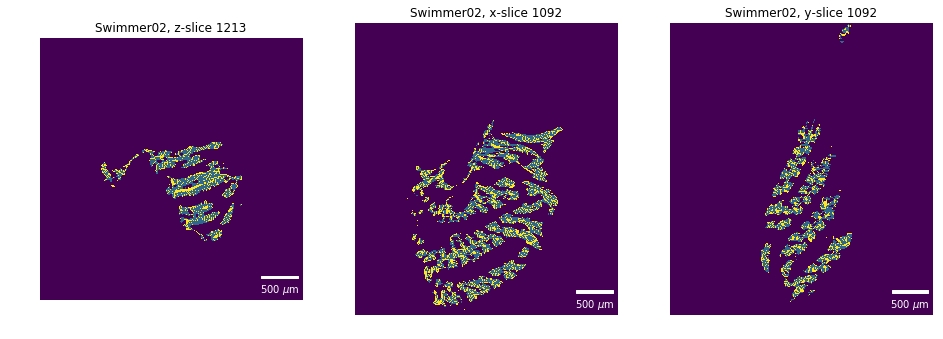

13/20: Saving difference images for sample Swimmer03


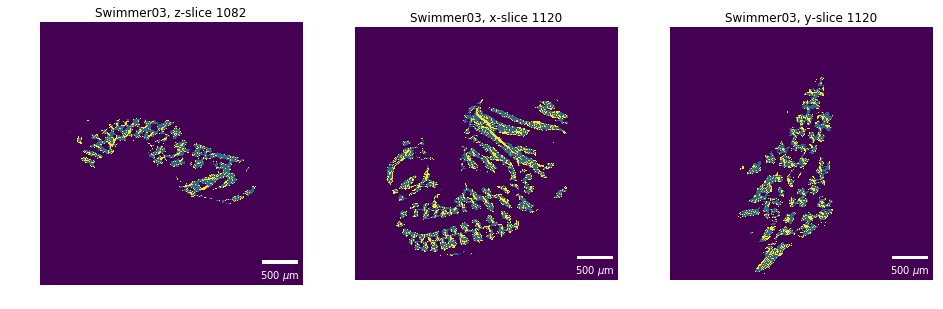

14/20: Saving difference images for sample Swimmer04


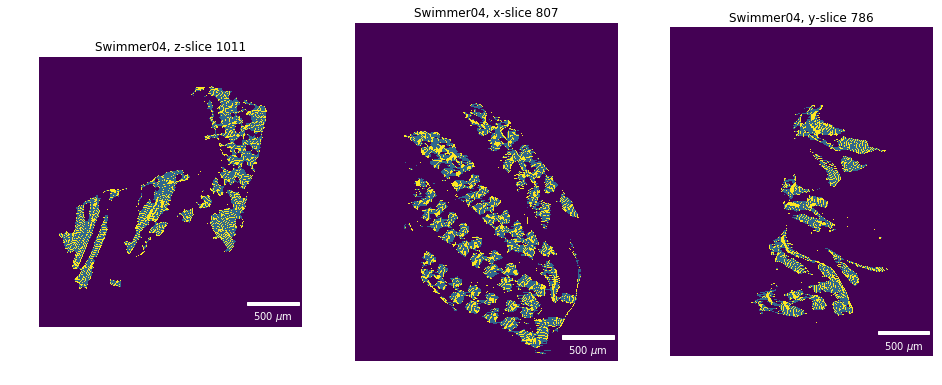

15/20: Saving difference images for sample Swimmer05_Rescan


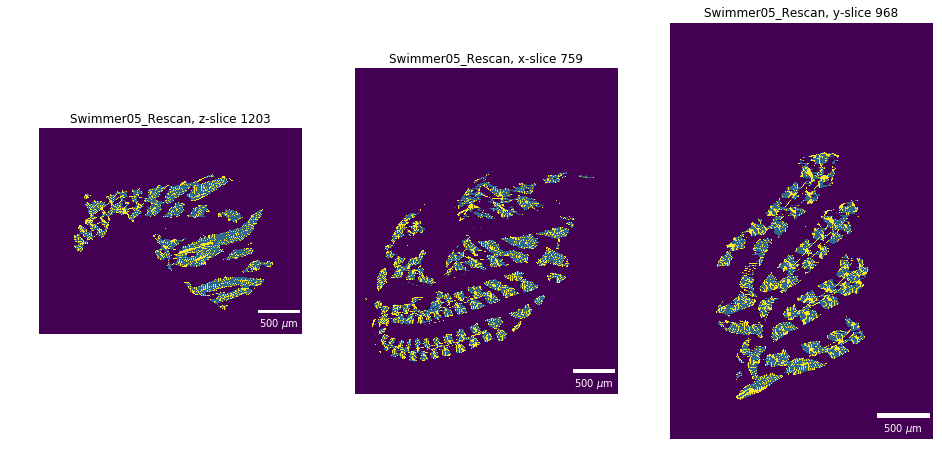

16/20: Saving difference images for sample Swimmer06


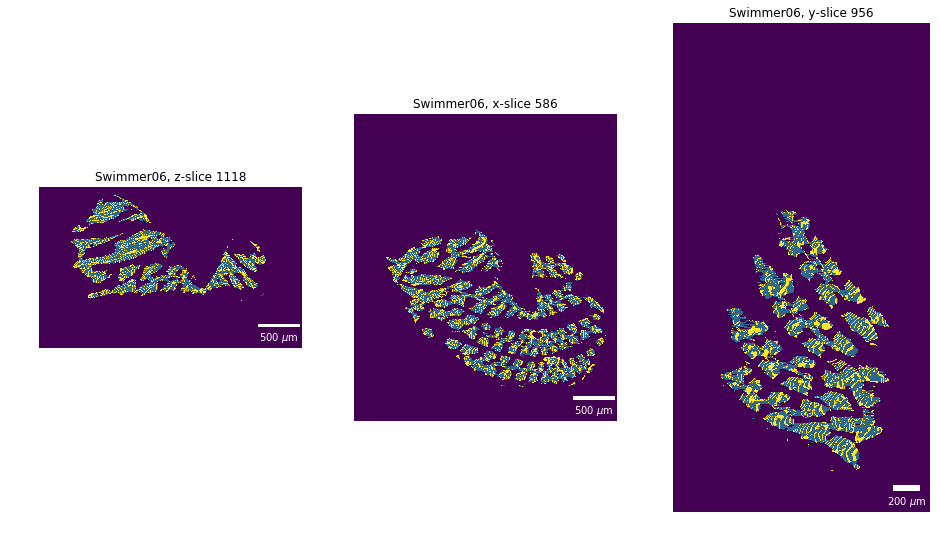

17/20: Saving difference images for sample Swimmer07


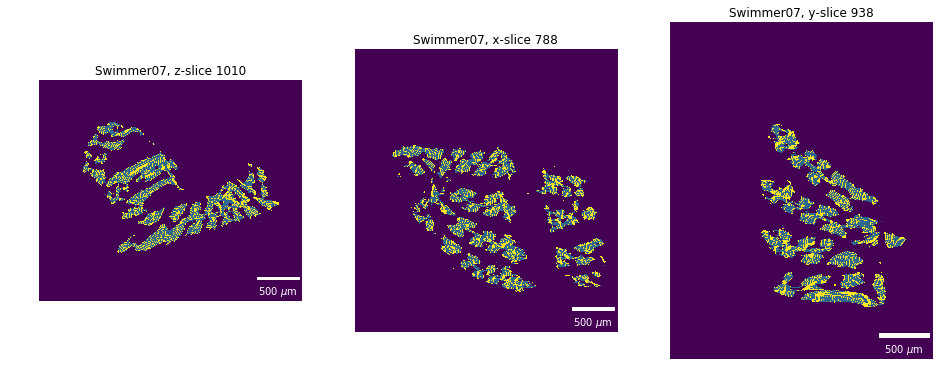

18/20: Saving difference images for sample Swimmer08


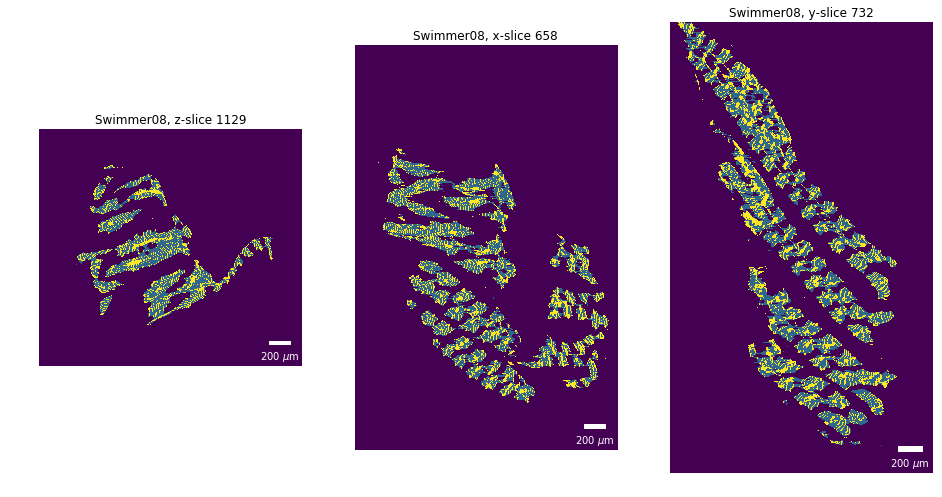

19/20: Saving difference images for sample Swimmer09


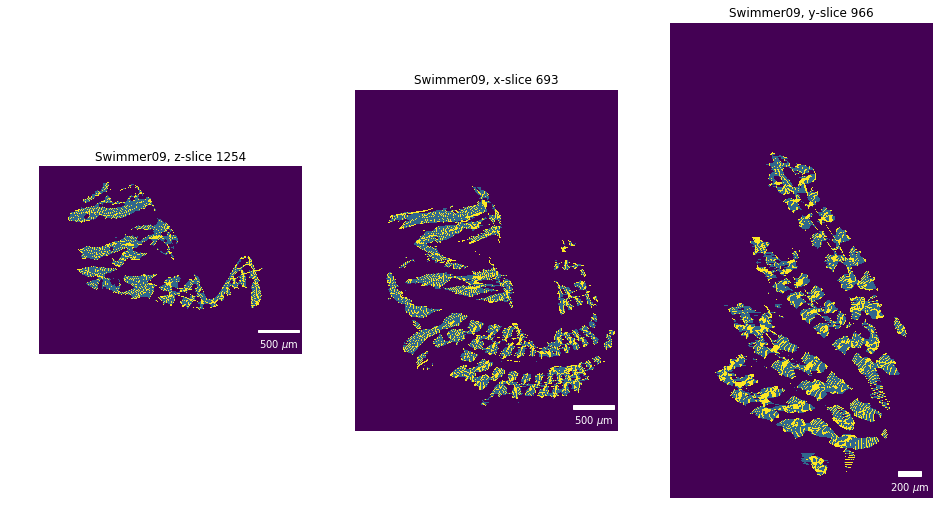

20/20: Saving difference images for sample Swimmer10


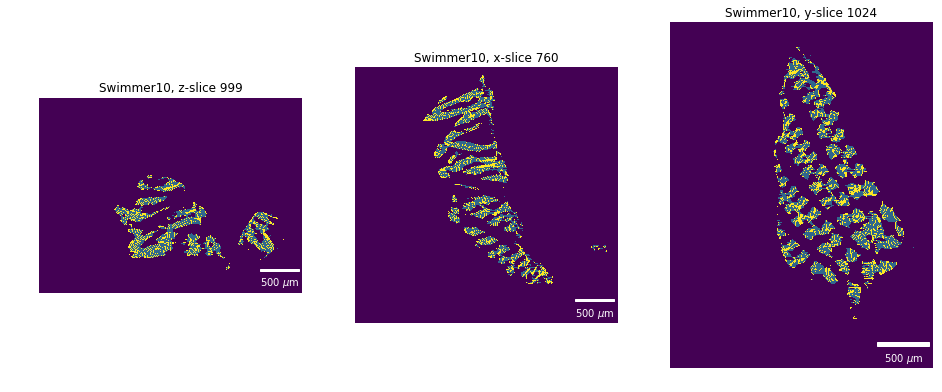

In [135]:
# Do the deeds
for c, i in Data.iterrows():
    print('%02s/%s: Saving difference images for sample %s' % (c + 1,
                                                               len(Data),
                                                               i.Sample))
    display_difference(c)

In [ ]:
print('Saved all difference images to %s' % OutPutDir)